# Pore detection and analysis (sizes)
### mature = NPC *vs* intermediate = PI 

This notebook should be run on 2-colour images with POM121 labeled in the Star635P channel to get the best resolution.

Here is the workflow:

1. Preprocess images (outliers removed, min-max adjusted, smoothed,  out-of-focus areas removal)
>function **process.py**
2. Calculate thresholds for POM121 and mAb414 channels (Otsu method)
3. Detect POM121 and mAB414 spots with Astropy.
>function **detect.py**
4. Sort out PIs and NPCs (calculate min distance between POM121 and mAb414)
>function **mindist.py**
5. Visualize and save results
6. Measure rotationally averaged line profiles
>function **line_profile.py**
>save data
7. Fit profiles with 1 gaussian. Extract parameters.
>function **iterative_functions.py**
>save data
8. Calculate and plot the size distributions.
>function
>save data



## Table of content:
* [Import libraries](#libraries)
* [Pre-process images](#pre-processing)
* [Detect peaks](#detect)
* [Sort pore types](#sorting)
* [Analyze pore intermediate](#results)



---

## Import libraries <a class="anchor" id="libraries"></a>



In [1]:
# Import packages

import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import array
import skimage.filters as skfilt
from scipy import ndimage
from skimage.filters import threshold_otsu


from iterative_functions import lorentzian, gaussian, iterative_fit
from nucmask import nucleus_mask, nucleus_focus_mask
from process import process
from detect import detect_pores
from line_profile import generate_line_profile, generate_rotational_line_profile
from mindist import shorter_dist, closest_point

---

## Pre-process images <a class="anchor" id="pre-processing"></a>


In [2]:
## Load data and paths

dirpath = '/Users/christine/Documents/Data/STED/Data_for_analysis/SampleTest'
outputpath = '/Users/christine/Documents/Data/STED/Data_for_analysis/Results/20230425_10:04'


mABpath = '/Users/christine/Documents/Data/STED/Data_for_analysis/SampleTest/200812_siNup53-2.msr_414.tif'
POMpath = '/Users/christine/Documents/Data/STED/Data_for_analysis/SampleTest/200812_siNup53-2.msr_POM.tif'

imgname = '200812_siNup53-2'
condition = 'siNup53'



In [3]:
## Define parameter constants

# Gaussian size in nm for denoising
gf_nm = 10 
# size of the low-pass filter for removal of out-of-focus areas and deblurring
gaussstd_nm = 500
# Sigma for Gaussian filtering (for peak detection)
sm_size_nm = 30
# Peak distance (in nm) btw POM and mAB for pore sorting
min_peak_dist = 100


px size=  14.999999925000001


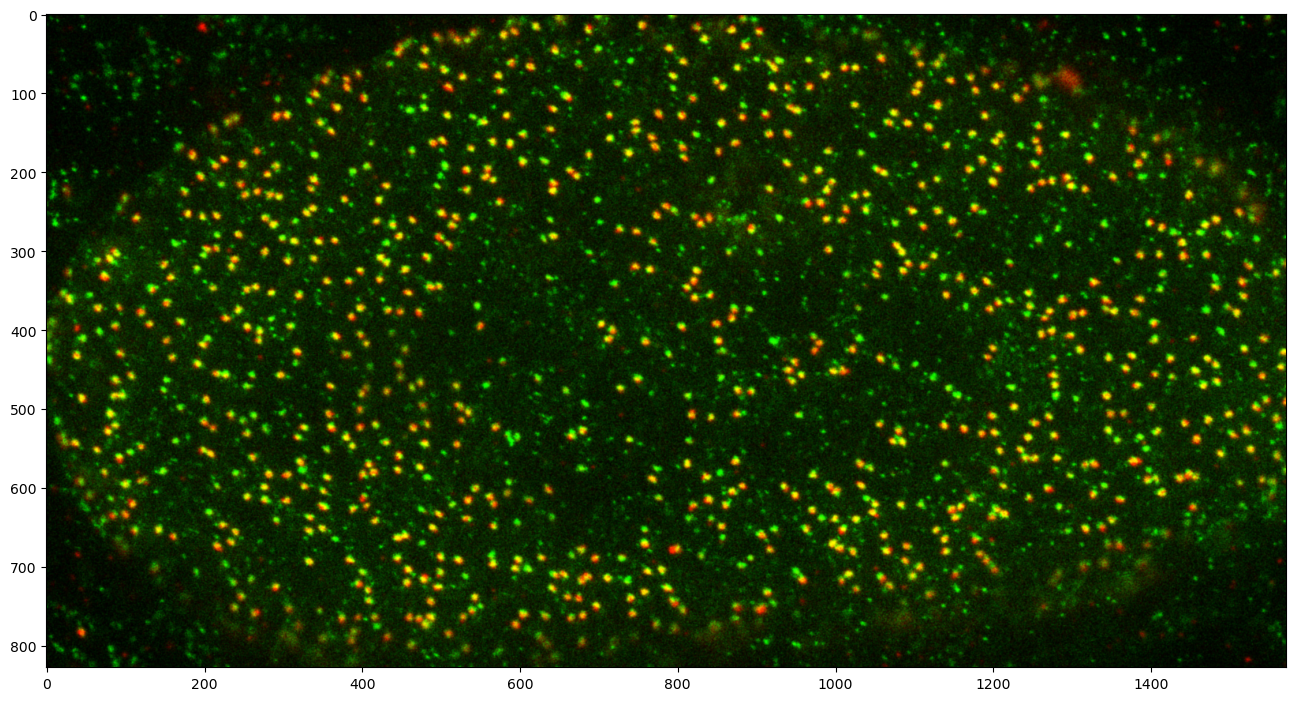

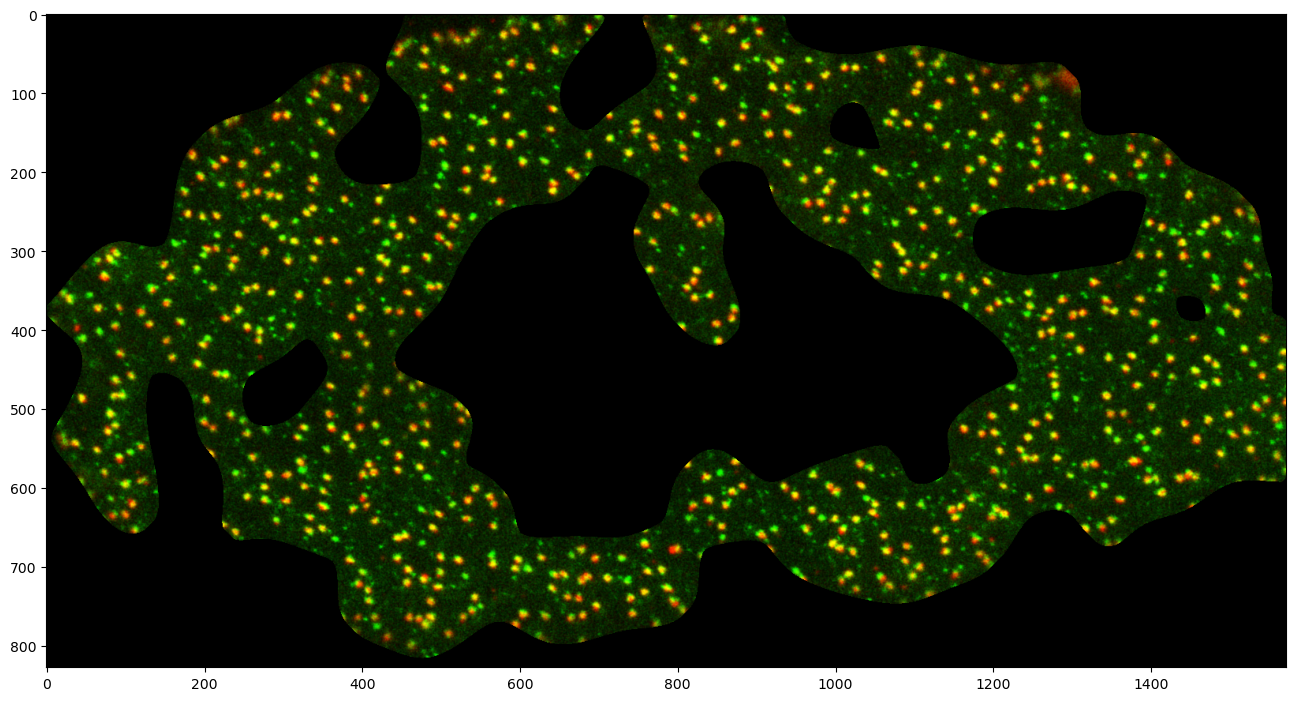

In [4]:
with tifffile.TiffFile(mABpath) as tif:
    mABraw = tif.pages[0].asarray()  # image as numpy array
    pxs_nm = 1e9/tif.pages[0].tags['XResolution'].value[0]  # pixel size in nm
    print('px size= ',pxs_nm)

with tifffile.TiffFile(POMpath) as tif:
    POMraw = tif.pages[0].asarray()  # image as numpy array
    #print(POMraw.shape)

# with tifffile.TiffFile(Nup96path) as tif:
#     Nup96raw = tif.pages[0].asarray()  # image as numpy array
    #print(Nup96raw.shape)

######################################################################################################################
## Pre-process images 

mAB = process(mABraw, gf_nm, pxs_nm)   
POM = process(POMraw, gf_nm, pxs_nm)
B = np.zeros(mAB.shape)
#   Nup96 = process(Nup96raw, gf_nm, pxs_nm)  

RGB0 = np.dstack((mAB,POM,B))
#   RGB0 = np.dstack((mAB,POM,Nup96))    


## Get binary mask
mask = nucleus_focus_mask(mAB, gaussstd_nm=500, pxs_nm=15, num_di=12, num_er=5)  


POMimg = POM*mask
mABimg = mAB*mask
#  Nup96img = Nup96*mask

RGB1 = np.dstack((mABimg,POMimg,B))
#  RGB1 = np.dstack((mABimg,POMimg,Nup96img))


fig,ax0 = plt.subplots(figsize=(16,16))
ax0.imshow(RGB0)

fig,ax1 = plt.subplots(figsize=(16,16))
ax1.imshow(RGB1)

    

---

## Detect peaks <a class="anchor" id="detect"></a>


(636, 2)
(1136, 2)


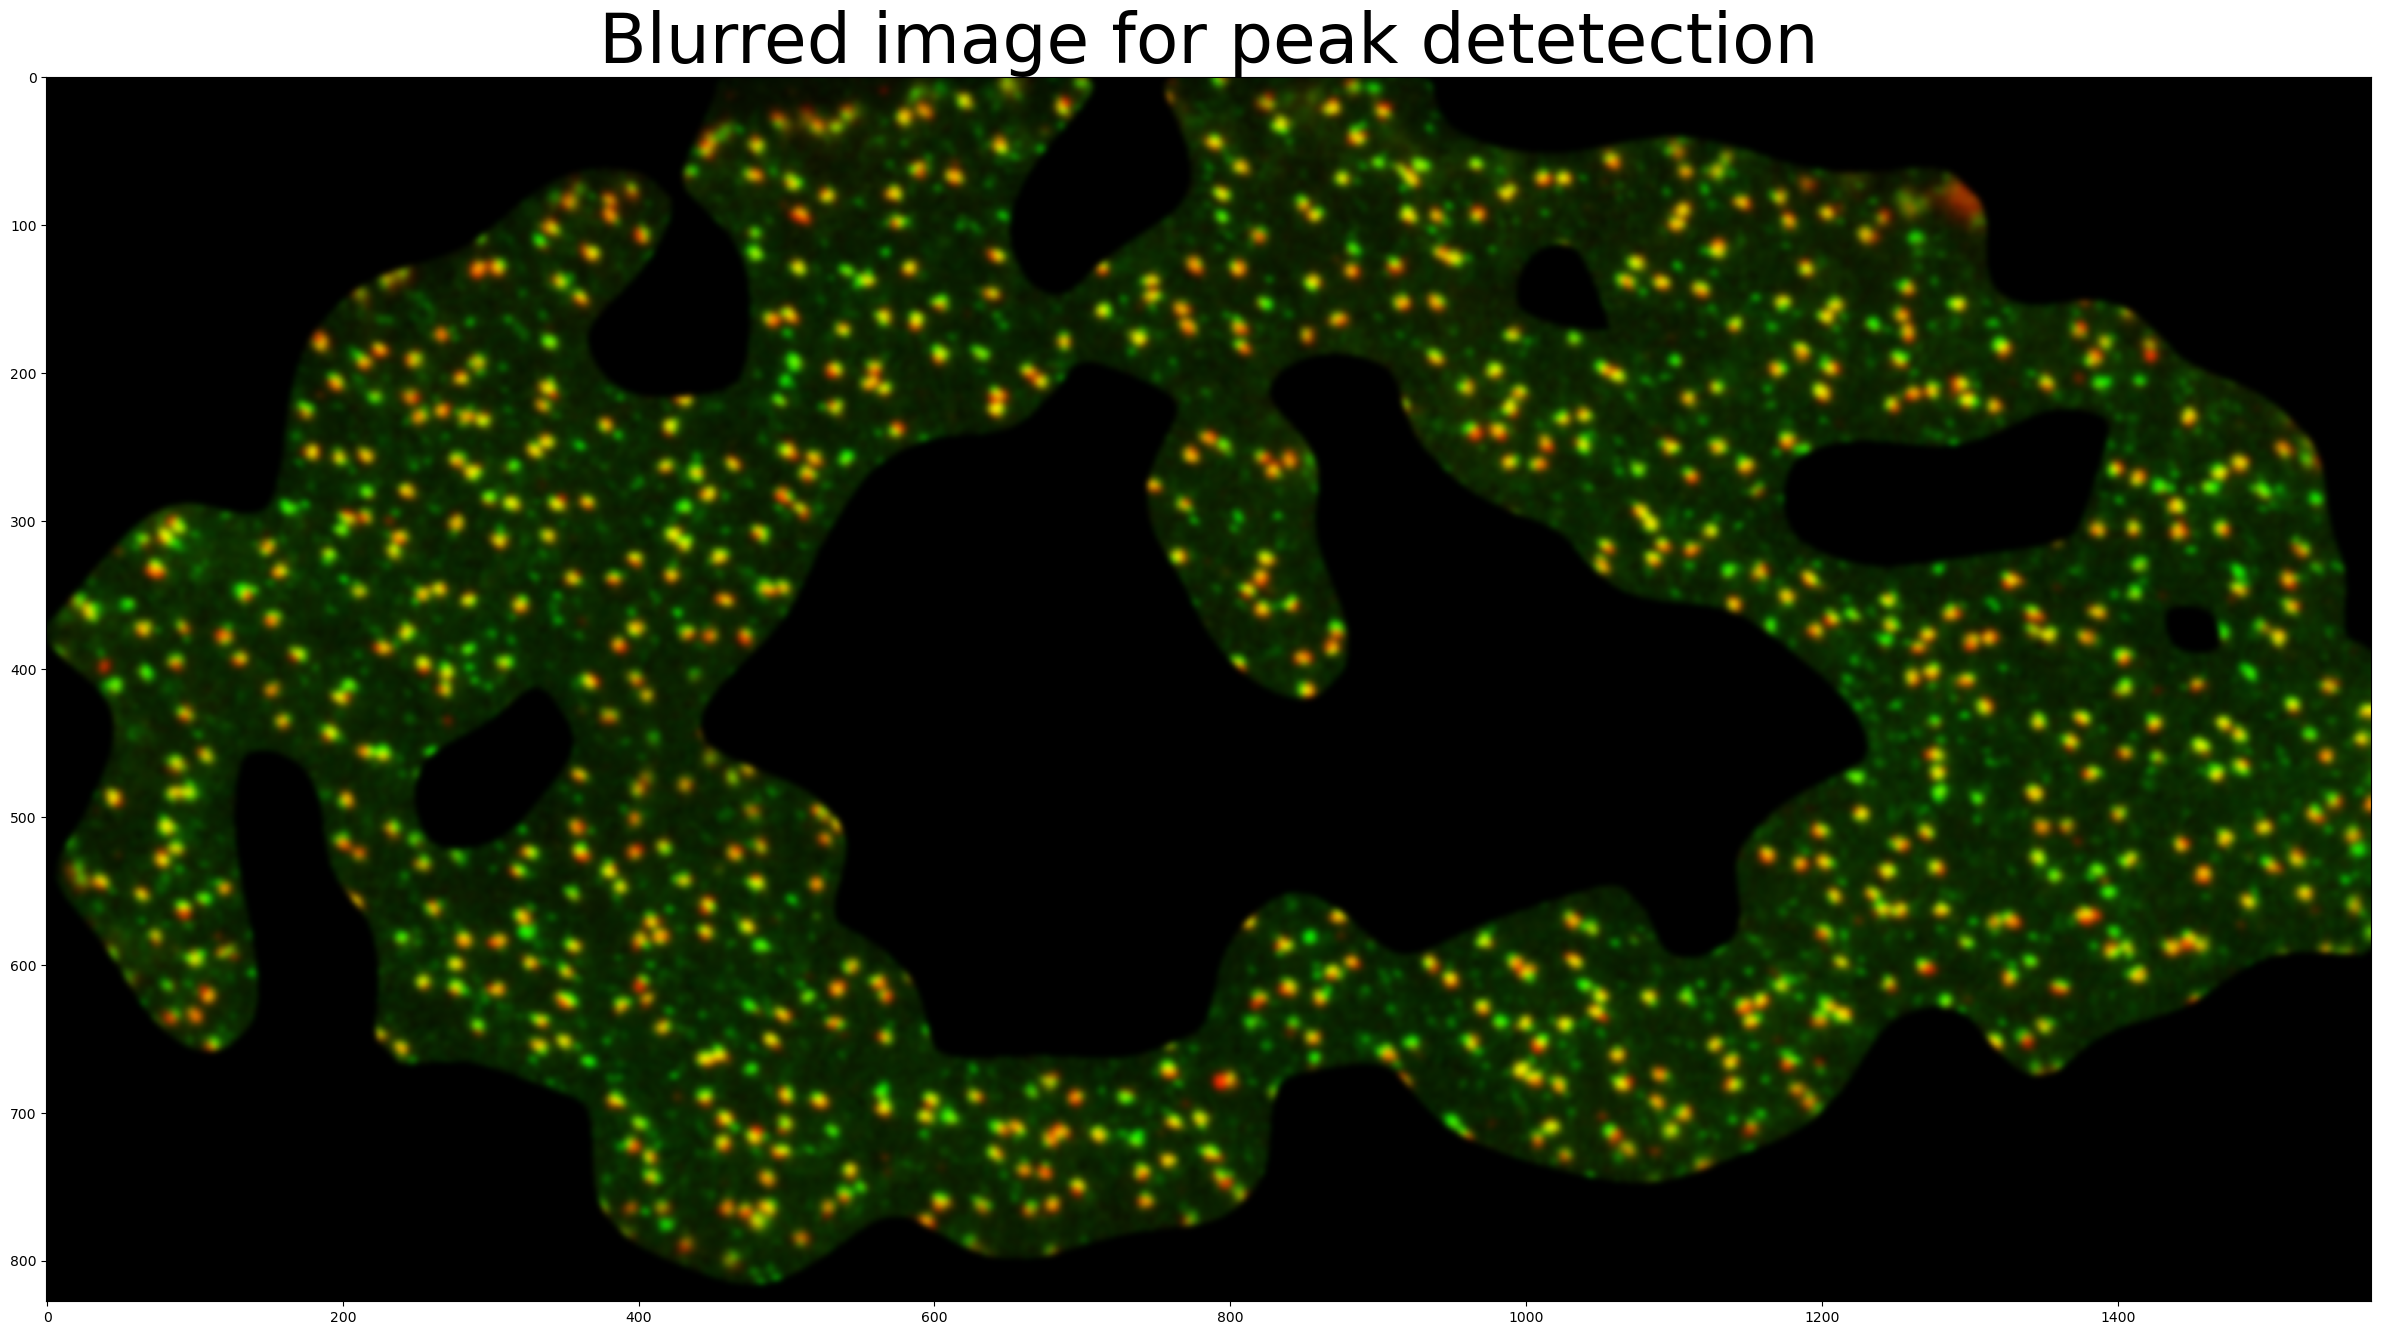

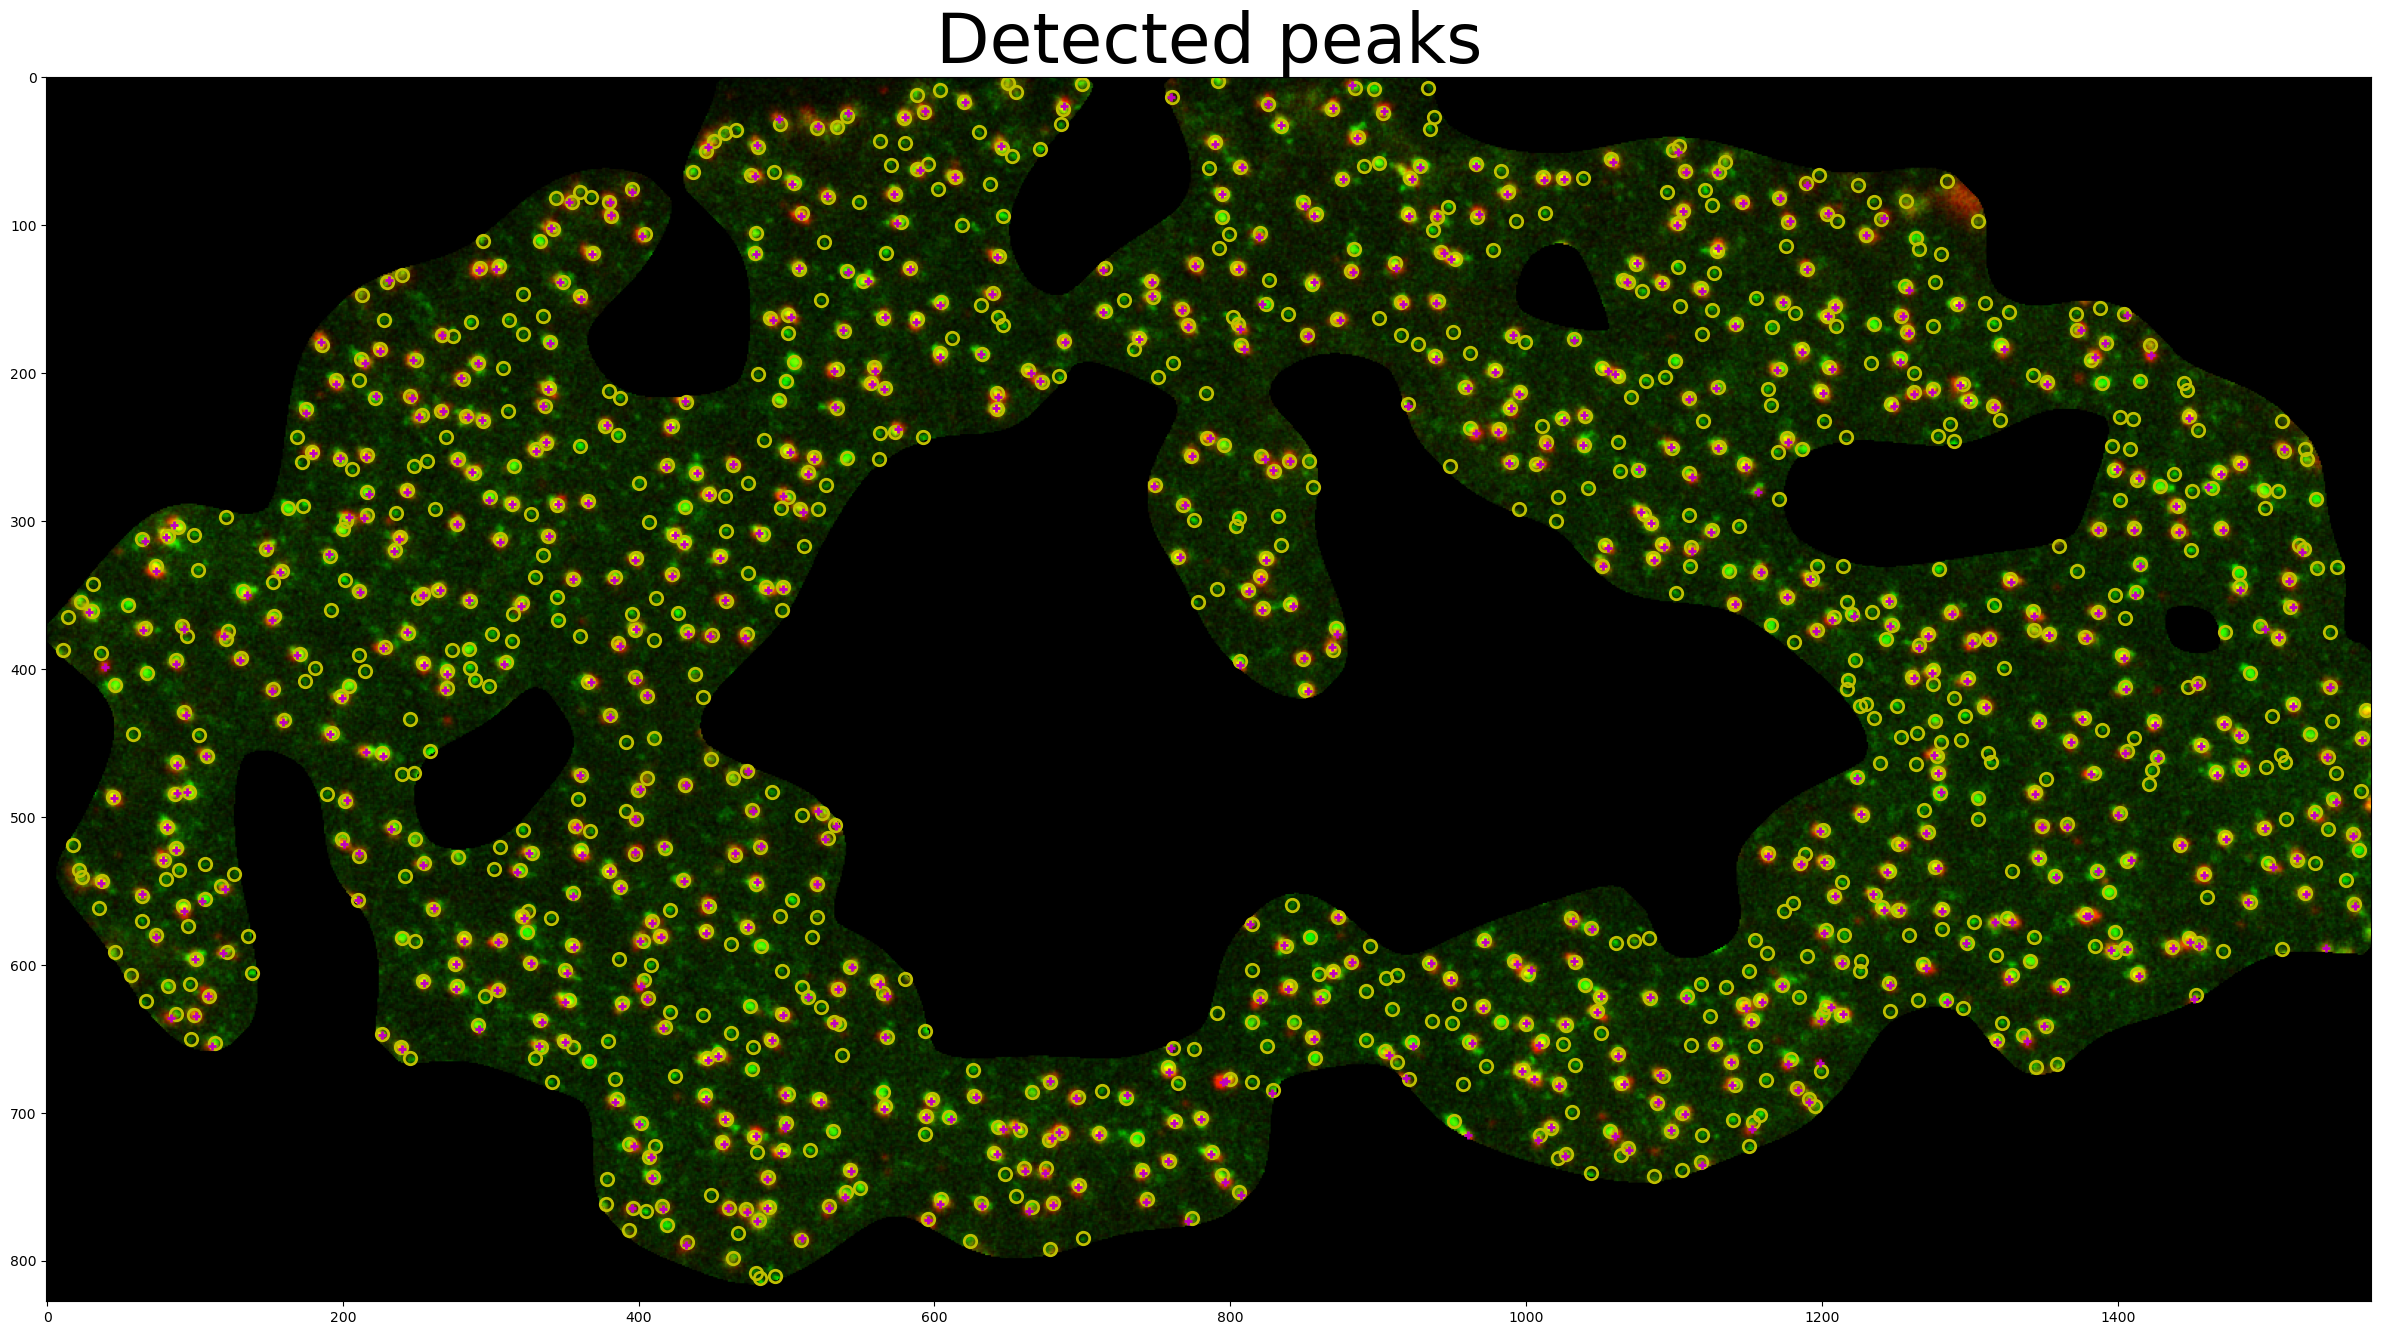

In [5]:
## Determine thresholds with otsu method
ThPOM = threshold_otsu(POMimg)-0.5*np.std(POMimg)  
ThmAB = threshold_otsu(mABimg)-0.5*np.std(mABimg)

## Apply Gaussian filter to POM and mAB images
POMfilt = ndimage.gaussian_filter(POMimg,sm_size_nm/pxs_nm)
mABfilt = ndimage.gaussian_filter(mABimg,sm_size_nm/pxs_nm)

RGB2 = np.dstack((mABfilt,POMfilt,B))
fig, ax2 = plt.subplots(figsize=(30,30))
ax2.set_title('Blurred image for peak detetection', fontsize=50)
plt.imshow(RGB2)

## Detect POM and mAB peaks
POMpeaks = detect_pores(POMfilt, threshold=ThPOM, fwhm=120/pxs_nm)
mABpeaks = detect_pores(mABfilt, ThmAB, fwhm=90/pxs_nm)
#print(POMpeaks)

fig, ax3 = plt.subplots(figsize=(30,30))
plt.imshow(RGB1)
ax3.scatter(POMpeaks[:,0], POMpeaks[:,1], s=80,c='#FF000000',marker='o',edgecolors='y',linewidths=2)
ax3.scatter(mABpeaks[:,0], mABpeaks[:,1], s=30,c='m', marker='+',linewidths=2)
ax3.set_title('Detected peaks', fontsize=50)

print(mABpeaks.shape)
print(POMpeaks.shape)


---

## Sort pores <a class="anchor" id="sorting"></a>


In [6]:
## NPCs = all mAB peaks
# Extract the date of the experiment 
date_exp=imgname.split('_')[0]
print(date_exp)

# create an Empty DataFrame object
df = pd.DataFrame()
 
# append columns to an empty DataFrame
df['Date'] = [date_exp for i in range (len(mABpeaks))]
df['Pore_Status'] = ['NPC' for i in range(len(mABpeaks))]
df['x_coordinate'] = mABpeaks[:,0]
df['y_coordinate'] = mABpeaks[:,1]
df['mAB414_POM121_distance']=(['NaN' for i in range (len(mABpeaks))])
 
df


200812


Date Pore_Status  x_coordinate  y_coordinate mAB414_POM121_distance
0    200812         NPC    882.309327      5.171945                    NaN
1    200812         NPC    759.803834     13.366682                    NaN
2    200812         NPC    620.866816     16.328934                    NaN
3    200812         NPC    687.425476     19.270874                    NaN
4    200812         NPC    825.211618     17.906798                    NaN
..      ...         ...           ...           ...                    ...
631  200812         NPC    595.335593    772.814144                    NaN
632  200812         NPC    771.687810    772.921907                    NaN
633  200812         NPC    479.929255    773.158434                    NaN
634  200812         NPC    510.208751    784.988781                    NaN
635  200812         NPC    431.815544    789.768516                    NaN

[636 rows x 5 columns]

In [7]:
## PIs: they should be at least 'min_peak_dist' away from mAB peak

dist = min_peak_dist/pxs_nm
#PI = 0
PI_coord = np.array([])

#npc=np.array([df['x_coordinate'],df['y_coordinate']])
#print(npc)

mAB_POM_dist = []
#fig, ax = plt.subplots(figsize=(30,30))
#plt.imshow(RGB2)
#ax.scatter(mABpeaks[:,0], mABpeaks[:,1], s=30,c='m', marker='+',linewidths=2)
pore_status = []

for i in range (0,len(POMpeaks)):
    if shorter_dist(POMpeaks[[i]],mABpeaks)>=dist:
        mAB_POM_dist.append(shorter_dist(POMpeaks[[i]],mABpeaks)*pxs_nm)
        #PI=PI+1
        PI_coord = np.append(PI_coord,np.array(POMpeaks[[i]])) # On récupère les coordonnées POM121 de chaque pore immature 
        PI_coord = np.reshape(PI_coord,(-1,2))
        pore_status.append('PI')
        #ax.scatter(POMpeaks[i,0], POMpeaks[i,1], s=80,c='#FF000000',marker='o',edgecolors='y',linewidths=2)
        
#print(PI_coord)
#print(mAB_POM_dist)
#print(PI)
#print(type(pore_status))
df2 = pd.DataFrame()
df2['Date'] = [date_exp for i in range (len(PI_coord))]
df2['Pore_Status'] = ['PI' for i in range (len(PI_coord))]
df2['x_coordinate'] = PI_coord[:,0]
df2['y_coordinate'] = PI_coord[:,1]

df2['mAB414_POM121_distance']=[mAB_POM_dist[i] for i in range (len(PI_coord))]
print(df2)

       Date Pore_Status  x_coordinate  y_coordinate  mAB414_POM121_distance
0    200812          PI    649.594456      4.051949              468.615381
1    200812          PI    791.820258      2.703916              506.179653
2    200812          PI    699.638150      4.259928              290.271472
3    200812          PI    603.745372      8.694534              261.274618
4    200812          PI    933.862685      7.013280              509.584916
..      ...         ...           ...           ...                     ...
491  200812          PI    677.943341    792.080719              439.696062
492  200812          PI    463.487097    798.064679              447.660312
493  200812          PI    479.292581    808.414712              528.930393
494  200812          PI    492.371319    810.091013              461.916239
495  200812          PI    482.282208    811.980273              582.578144

[496 rows x 5 columns]


In [8]:
df_final=pd.concat([df,df2],ignore_index=True)
print(df_final)
df_final.to_csv(outputpath+'/pores.csv')


        Date Pore_Status  x_coordinate  y_coordinate mAB414_POM121_distance
0     200812         NPC    882.309327      5.171945                    NaN
1     200812         NPC    759.803834     13.366682                    NaN
2     200812         NPC    620.866816     16.328934                    NaN
3     200812         NPC    687.425476     19.270874                    NaN
4     200812         NPC    825.211618     17.906798                    NaN
...      ...         ...           ...           ...                    ...
1127  200812          PI    677.943341    792.080719             439.696062
1128  200812          PI    463.487097    798.064679             447.660312
1129  200812          PI    479.292581    808.414712             528.930393
1130  200812          PI    492.371319    810.091013             461.916239
1131  200812          PI    482.282208    811.980273             582.578144

[1132 rows x 5 columns]


In [9]:
# To be done: append an existing .csv file each time we run the code 

---

## Analyze pore intermediates <a class="anchor" id="analysis"></a>


Here the goal is to extract fluorescence intensity profiles from every NPC and PI position, in 2 (mAb414 + POM121) or 3 channels (+ additional Nup if available).

1. for each image, 
    - load the 2 or 3 channels, 
    - build RGB and show image.
    - Load pore positions.
2. for each NPC position
    - plot NPC position on the RGB image
    - measure rotationally averaged profile in 2 or 3 channels
    - represent them (superimposed)
    - save: make a new data frame which is the copy of the previous one + profiles.
3. do the same for PIs
4. Once all this works
    - fit the profiles
    - extract parameters
    - calculate diameter (when 2 or more gaussians)
    - save results in the previous dataframe
    
---

### Linear interpolation along the line



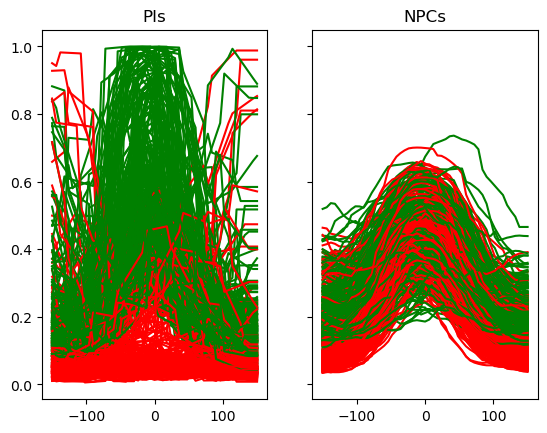

In [19]:
## set parameters for line profiles

pores = pd.read_csv(outputpath+'/pores.csv', sep=',')

angle_bin = 20
length = round(300/pxs_nm)
bins = 51

x = np.linspace(-150,150,bins)

PIs = pores[pores['Pore_Status']=='PI']

fig, (ax4,ax5) = plt.subplots(nrows=1, ncols=2, sharey=True)
for i in range (0,len(PIs)):
    x0 = PIs['x_coordinate'].iloc[i]
    y0 = PIs['y_coordinate'].iloc[i]
   
    POM_profile = generate_line_profile(POM, (x0, y0), angle_bin, length, bins)
    mAB_profile = generate_line_profile(mAB, (x0, y0), angle_bin, length, bins)
    #NupX_profile = generate_line_profile(NupX, (x0, y0), angle_bin, length, bins)
    
    #print(POM_profile)
    ax4.plot(x,mAB_profile,'r')
    ax4.plot(x,POM_profile,'g')
    #ax4.plot(x,NupX_profile,'b')
    ax4.set_title('PIs')
    
    
NPCs = pores[pores['Pore_Status']=='NPC']

for i in range (0,len(NPCs)):
    #print(i)
    x0 = NPCs['x_coordinate'].iloc[i]
    y0 = NPCs['y_coordinate'].iloc[i]
    
    POM_profile = generate_rotational_line_profile(POM, (x0, y0), angle_bin, length, bins)
    mAB_profile = generate_rotational_line_profile(mAB, (x0, y0), angle_bin, length, bins)
    #NupX_profile = generate_rotational_line_profile(NupX, (x0, y0), angle_bin, length, bins)

    ax5.plot(x,mAB_profile,'r')
    ax5.plot(x,POM_profile,'g')
    #ax5.plot(x,NupX_profile,'b')
    ax5.set_title('NPCs')
    



#### Conclusion on this: 

It seems to work OK. Let's start with this.

Next step is to fit the profiles with 1, 2, 3 or 4 gaussians, extract parameters, calculate diameters...





In [11]:
#### Scan pore coordinates and images
prev_col = pores.columns
data=[]

images = np.unique(pores['Date'])
#print(images)

In [13]:
pxs_nm=15
l = (L/pxs_nm)/2 # length of the line in px

for j in range(0,len(images)):
    imgname = images[j]
    
    #### Trace rotationally averaged intensity profiles
    
    pores_j=pores[pores['Date']==imgname]
    
    for i in range(67,len(pores_j)): 
        prev_data=pores_j.iloc[i,:]    

        ## length of the line in px
        #pxs_nm = pores_j.iloc[i,3]
        l = (L/pxs_nm)/2     

        ## coordinates of pore centers
        xo = prev_data['x_coordinate']
        yo = prev_data['y_coordinate']
        print(xo,yo)
        ## Rotate the line and define its extremities
        POMprof_a=[]
        mABprof_a=[]
        
        for a in range(0,171,9): 

            src = xo-l*np.cos(a), yo-l*np.sin(a)
            dst = xo+l*np.cos(a), yo+l*np.sin(a)
            
            #bins = l
            x, y = src + np.array([np.cos(a), np.sin(a)])[:,0] * (l+1)
    
    # Interpolate the values of the image along the line
    values = map_coordinates(image, np.vstack((y, x)))
    
    # Calculate the average or sum of the values within each bin
    profile, _ = np.histogram(bins, bins=num_bins, weights=values)
    
    # Calculate the centers of the bins
    bin_width = bins[1] - bins[0]
    bin_centers = bins[:-1] + bin_width / 2
    
            

            POMprof_a.append(y_p)
            mABprof_a.append(y_m)

        print(POMprof_a)
        POMprof_i = np.mean(POMprof_a, axis=0)
        mABprof_i = np.mean(mABprof_a, axis=0)

        centers=np.linspace(-L/2,L/2,len(POMprof_i))
        x=np.linspace(-L/2,L/2,120)
################################################################ Jusqu'à ici tout semble fonctionner - le ne comprends pas pourquoi a va de 0 à 171



    #### POM121 channel

        channel = 'POM121'

    #### Fit pore profile with 1 or 2 Lorentzian
        f = lorentzian
        try:
            n, popt, pcov, r_sq, residuals = iterative_fit(f,centers,POMprof_i,nb_iterations=2) 
            '''Iterative fit contains a function called curve_fit that use non-linear least squares to fit a function,
            f, to data'''
        
        except RuntimeError:
            pass
        new_data=[channel,centers,POMprof_i,f,n,r_sq,popt]
        data.append([*prev_data,*new_data])
    
#### Fit pore profile with 1 or 2 Gaussians
        f = gaussian
        try:
            n, popt, pcov, r_sq, residuals = iterative_fit(f,centers,POMprof_i,nb_iterations=2)
        except RuntimeError:
            pass
        
        new_data=[channel,centers,POMprof_i,f,n,r_sq,popt]
        data.append([*prev_data,*new_data])

    #### mAb414 channel

        channel = 'mAb414'

    #### Fit pore profile with 1 or 2 Lorentzian
        f = lorentzian
        try: 
            n, popt, pcov, r_sq, residuals = iterative_fit(f,centers,mABprof_i,nb_iterations=2)
        #ax0.plot(x,f(x, *popt),c='c', linestyle='--')
        #print(f, n,r_sq)
        except RuntimeError:
            pass
        new_data=[channel,centers,mABprof_i,f,n,r_sq,popt]
        data.append([*prev_data,*new_data])

    #### Fit pore profile with 1 or 2 Gaussians
        f = gaussian
        try:
            n, popt, pcov, r_sq, residuals = iterative_fit(f,centers,mABprof_i,nb_iterations=2)
        
        except RuntimeError:
            pass
        new_data=[channel,centers,mABprof_i,f,n,r_sq,popt]
        data.append([*prev_data,*new_data])
    
new_col = ['Channel','Centers (nm)','Intensity','Function','nb iterations','R2','*popt']   
col=[*prev_col,*new_col]
df=pd.DataFrame(data,columns=col)
df

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 49)

In [ ]:
import numpy as np
from scipy.ndimage import map_coordinates

def measure_line_profile(image, point1, point2, num_bins):
    """
    Measure the intensity profile of an image along a line with constant binning,
    regardless of the orientation of the line.
    
    Parameters
    ----------
    image : ndarray
        The input image.
    point1, point2 : array_like
        The coordinates of the two points defining the line.
    num_bins : int
        The number of bins to use for the intensity profile.
    
    Returns
    -------
    bins : ndarray
        The centers of the bins used for the intensity profile.
    profile : ndarray
        The intensity profile of the image along the line.
    """
    # Calculate the distance and angle between the two points
    delta = np.subtract(point2, point1)
    distance = np.sqrt(np.sum(delta**2))
    angle = np.arctan2(delta[1], delta[0])
    
    # Generate a set of num_bins evenly spaced along the line
    bins = np.linspace(0, distance, num_bins)
    x, y = point1 + np.array([np.cos(angle), np.sin(angle)])[:, None] * bins
    
    # Interpolate the values of the image along the line
    values = map_coordinates(image, np.vstack((y, x)))
    
    # Calculate the average or sum of the values within each bin
    profile, _ = np.histogram(bins, bins=num_bins, weights=values)
    
    # Calculate the centers of the bins
    bin_width = bins[1] - bins[0]
    bin_centers = bins[:-1] + bin_width / 2
    
    return bin_centers, profile


In [ ]:


# Define the coordinates of the two points
point1 = src
point2 = dst

# Measure the intensity profile
num_bins = 20
bins, profile = measure_line_profile(POM, point1, point2, num_bins)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.imshow(POM)
ax1.plot([point1[0], point2[0]], [point1[1], point2[1]], 'r-')
ax1.set_title('Input image with line')

ax2.plot(bins, profile)
ax2.set_title('Intensity profile')
ax2.set_xlabel('Distance along line')
ax2.set_ylabel('Intensity')

plt.show()


In [ ]:
print(centers)

In [ ]:
print(mABprof_a)